In [1]:
import os

%matplotlib inline
import string
import sys
import seaborn as sn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statistics

sys.path.append("code/.")
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import StackingClassifier
import eli5

## Fantasy Baseball 2023 Pitcher Projections
Following up on the batter projections, I will now be creating projections for pitchers. The pitcher projections will consist of training a regression model to predict the fantasy score per innings for all categories of pitchers (starters, relievers and closers). However fantasy points per inning will be calculated solely on individual statistics (Hits, Walks, Strikeouts, Innings Pitched and Earned Runs), as team related statistics (Wins, Losses, Saves, Holds) are very situation dependent and should not be used in future predictions. In order to account for these team related statistics, I will utilize Razzball's predictions for wins, losses, saves and holds and add these predictions into the results from the model. Once again team factor will be calculated and applied by standardizing team performance. This will account for team performance and opportunities for wins, losses, etc. along with accounting for the impact of ballpark dimensions and climate. Innings pitched for 2023 will also be taken from Razzball and applied to the per inning predictions to produce the final predictions for the 2023 season. 

In [2]:
os.chdir("/Users/matthewgillies/FantasyPreds2023")
data = pd.read_csv("data/Pitchfull.csv", index_col = 0)
data = data.drop(columns = "S")
data.head()

year  p_k_percent  p_bb_percent   xslg  xwoba   xobp  \
player                                                                   
Wainwright, Adam  2022         21.0           6.0  0.388  0.302  0.305   
Greinke, Zack     2022         17.2           5.2  0.430  0.320  0.307   
Jansen, Kenley    2022         30.9          12.9  0.270  0.260  0.295   
Chavez, Jesse     2022         27.1           8.3  0.345  0.271  0.277   
Detwiler, Ross    2022         27.1           8.7  0.392  0.316  0.317   

                  xwobacon  exit_velocity_avg  launch_angle_avg  \
player                                                            
Wainwright, Adam     0.353               88.2              10.0   
Greinke, Zack        0.365               88.3              10.6   
Jansen, Kenley       0.310               84.0              19.8   
Chavez, Jesse        0.335               90.9              10.4   
Detwiler, Ross       0.383               88.3              15.3   

                  sweet_spot_percent  ...  out_zone_percent  edge_percent  \
player                                ...                                   
Wainwright, Adam                34.3  ...              50.5          45.4   
Greinke, Zack                   35.3  ...              54.1          42.9   
Jansen, Kenley                  30.1  ...              47.6          41.5   
Chavez, Jesse                   29.1  ...              47.0          41.7   
Detwiler, Ross                  30.2  ...              52.5          44.9   

                  whiff_percent  swing_percent  f_strike_percent  \
player                                                             
Wainwright, Adam           19.7           43.8              64.4   
Greinke, Zack              21.8           46.0              66.0   
Jansen, Kenley             33.1           50.1              62.8   
Chavez, Jesse              17.7           43.9              65.2   
Detwiler, Ross             24.0           45.0              53.7   

                  groundballs_percent  flyballs_percent  linedrives_percent  \
player                                                                        
Wainwright, Adam                 48.7              21.5                25.4   
Greinke, Zack                    45.6              23.9                25.0   
Jansen, Kenley                   37.9              30.1                19.0   
Chavez, Jesse                    43.0              29.1                26.7   
Detwiler, Ross                   39.6              31.7                18.7   

                  popups_percent  Fpointsper  
player                                        
Wainwright, Adam             4.4    1.634937  
Greinke, Zack                5.4    1.372263  
Jansen, Kenley              13.1    2.531250  
Chavez, Jesse                1.2    1.914616  
Detwiler, Ross              10.1    1.505747  

[5 rows x 25 columns]

In [3]:
## Checking for NA Values
data.isna().any()

year                     False
p_k_percent               True
p_bb_percent              True
xslg                      True
xwoba                     True
xobp                      True
xwobacon                  True
exit_velocity_avg         True
launch_angle_avg          True
sweet_spot_percent        True
barrel_batted_rate        True
z_swing_percent           True
z_swing_miss_percent      True
oz_swing_percent          True
oz_swing_miss_percent     True
out_zone_percent          True
edge_percent              True
whiff_percent             True
swing_percent             True
f_strike_percent          True
groundballs_percent       True
flyballs_percent          True
linedrives_percent        True
popups_percent            True
Fpointsper               False
dtype: bool

In [4]:
## Dropping NA rows
data = data.dropna()

In [5]:
data.shape

(1118, 25)

In [6]:
## Removing the year column as the model should not take the year into account for future predictions
data = data.drop(columns = 'year')

In [7]:
## Data splitting with 70/30 split
X = data.drop(columns = "Fpointsper")
y = data["Fpointsper"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
X_train.head()

p_k_percent  p_bb_percent   xslg  xwoba   xobp  xwobacon  \
player                                                                       
Melancon, Mark           17.8           8.0  0.459  0.356  0.361     0.408   
Bassitt, Chris           20.1           9.3  0.368  0.306  0.314     0.332   
Canning, Griffin         23.5           9.7  0.423  0.320  0.311     0.377   
Springs, Jeffrey         22.0           9.9  0.409  0.326  0.335     0.379   
Hughes, Jared            18.7           9.3  0.400  0.314  0.322     0.346   

                  exit_velocity_avg  launch_angle_avg  sweet_spot_percent  \
player                                                                      
Melancon, Mark                 88.8               6.7                34.4   
Bassitt, Chris                 85.8              11.8                32.9   
Canning, Griffin               88.9              18.9                30.4   
Springs, Jeffrey               86.7              17.6                41.1   
Hughes, Jared                  89.7               1.3                25.2   

                  barrel_batted_rate  ...  oz_swing_miss_percent  \
player                                ...                          
Melancon, Mark                   7.0  ...                   41.2   
Bassitt, Chris                   6.4  ...                   29.0   
Canning, Griffin                 8.9  ...                   48.2   
Springs, Jeffrey                 6.3  ...                   27.9   
Hughes, Jared                    6.8  ...                   33.3   

                  out_zone_percent  edge_percent  whiff_percent  \
player                                                            
Melancon, Mark                56.1          46.2           23.3   
Bassitt, Chris                49.1          41.0           17.3   
Canning, Griffin              55.1          40.6           27.1   
Springs, Jeffrey              46.5          45.5           27.0   
Hughes, Jared                 59.9          45.4           22.5   

                  swing_percent  f_strike_percent  groundballs_percent  \
player                                                                   
Melancon, Mark             45.9              57.6                 51.6   
Bassitt, Chris             44.4              59.3                 44.3   
Canning, Griffin           45.1              56.3                 36.7   
Springs, Jeffrey           44.8              60.7                 32.6   
Hughes, Jared              47.5              60.1                 60.2   

                  flyballs_percent  linedrives_percent  popups_percent  
player                                                                  
Melancon, Mark                13.3                31.3             3.9  
Bassitt, Chris                22.1                27.1             6.4  
Canning, Griffin              28.5                23.4            11.4  
Springs, Jeffrey              24.2                30.5            12.6  
Hughes, Jared                 15.5                21.4             2.9  

[5 rows x 23 columns]

In [8]:
## Further inspecting the data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 894 entries, Melancon, Mark to Wendelken, J.B.
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   p_k_percent            894 non-null    float64
 1   p_bb_percent           894 non-null    float64
 2   xslg                   894 non-null    float64
 3   xwoba                  894 non-null    float64
 4   xobp                   894 non-null    float64
 5   xwobacon               894 non-null    float64
 6   exit_velocity_avg      894 non-null    float64
 7   launch_angle_avg       894 non-null    float64
 8   sweet_spot_percent     894 non-null    float64
 9   barrel_batted_rate     894 non-null    float64
 10  z_swing_percent        894 non-null    float64
 11  z_swing_miss_percent   894 non-null    float64
 12  oz_swing_percent       894 non-null    float64
 13  oz_swing_miss_percent  894 non-null    float64
 14  out_zone_percent       894 non-null   

In [9]:
X_train.describe()

p_k_percent  p_bb_percent        xslg       xwoba        xobp  \
count   894.000000    894.000000  894.000000  894.000000  894.000000   
mean     23.904810      8.437808    0.395343    0.308942    0.310809   
std       5.887637      2.738409    0.063820    0.035000    0.033201   
min       9.100000      2.000000    0.196000    0.205000    0.194000   
25%      19.725000      6.700000    0.352250    0.284000    0.288000   
50%      23.300000      8.200000    0.395000    0.309500    0.311000   
75%      27.500000      9.900000    0.434000    0.332000    0.334000   
max      48.600000     19.500000    0.619000    0.429000    0.418000   

         xwobacon  exit_velocity_avg  launch_angle_avg  sweet_spot_percent  \
count  894.000000         894.000000        894.000000          894.000000   
mean     0.367639          88.351454         12.367562           32.993065   
std      0.037591           1.600466          5.566974            4.283516   
min      0.240000          82.700000        -10.900000           14.200000   
25%      0.343250          87.400000          9.000000           30.600000   
50%      0.366500          88.400000         12.350000           33.100000   
75%      0.390000          89.400000         16.000000           35.800000   
max      0.513000          94.400000         29.600000           49.300000   

       barrel_batted_rate  ...  oz_swing_miss_percent  out_zone_percent  \
count          894.000000  ...             894.000000        894.000000   
mean             7.037584  ...              43.451902         51.314318   
std              2.471943  ...               8.712689          3.343087   
min              0.700000  ...              21.700000         40.300000   
25%              5.400000  ...              37.150000         49.000000   
50%              6.900000  ...              42.800000         51.200000   
75%              8.600000  ...              49.300000         53.500000   
max             16.200000  ...              68.800000         62.800000   

       edge_percent  whiff_percent  swing_percent  f_strike_percent  \
count    894.000000     894.000000     894.000000        894.000000   
mean      42.592953      26.243065      47.225391         60.911409   
std        2.208075       5.166371       3.154973          4.660316   
min       34.900000      10.300000      36.100000         44.400000   
25%       41.200000      22.600000      45.200000         57.800000   
50%       42.600000      25.800000      47.200000         61.200000   
75%       44.100000      29.675000      49.275000         64.200000   
max       51.400000      47.800000      57.400000         74.400000   

       groundballs_percent  flyballs_percent  linedrives_percent  \
count           894.000000        894.000000          894.000000   
mean             44.388479         23.922483           24.335682   
std               8.318364          5.769449            3.713366   
min              21.700000          7.700000           10.000000   
25%              38.700000         20.000000           22.200000   
50%              44.300000         24.000000           24.400000   
75%              49.700000         27.800000           26.500000   
max              76.900000         45.800000           40.800000   

       popups_percent  
count      894.000000  
mean         7.353132  
std          3.131011  
min          0.000000  
25%          5.200000  
50%          7.000000  
75%          9.100000  
max         20.000000  

[8 rows x 23 columns]

In [10]:
## Analyzing correlations of features
corr_matrix = X_train.corr()
plt.figure(figsize = (100,100))
plt.rcParams.update({'font.size': 50})
sn.heatmap(corr_matrix, annot = True)

<AxesSubplot: >

There are many strong correlations within the dataset, which comes as expected due to the similarities and differences of many of the features. For example, groundball and flyball percentages have a strong negative correlation, which is intuitive as they are essentially opposites. On the other side of the spectrum, launch angle and flyball percentage have a very strong positive correlation. This is due to the fact that as launch angle increases, more flyballs will be given up, increasing flyball percentage. 

array([[<AxesSubplot: title={'center': 'p_k_percent'}>,
        <AxesSubplot: title={'center': 'p_bb_percent'}>,
        <AxesSubplot: title={'center': 'xslg'}>,
        <AxesSubplot: title={'center': 'xwoba'}>,
        <AxesSubplot: title={'center': 'xobp'}>],
       [<AxesSubplot: title={'center': 'xwobacon'}>,
        <AxesSubplot: title={'center': 'exit_velocity_avg'}>,
        <AxesSubplot: title={'center': 'launch_angle_avg'}>,
        <AxesSubplot: title={'center': 'sweet_spot_percent'}>,
        <AxesSubplot: title={'center': 'barrel_batted_rate'}>],
       [<AxesSubplot: title={'center': 'z_swing_percent'}>,
        <AxesSubplot: title={'center': 'z_swing_miss_percent'}>,
        <AxesSubplot: title={'center': 'oz_swing_percent'}>,
        <AxesSubplot: title={'center': 'oz_swing_miss_percent'}>,
        <AxesSubplot: title={'center': 'out_zone_percent'}>],
       [<AxesSubplot: title={'center': 'edge_percent'}>,
        <AxesSubplot: title={'center': 'whiff_percent'}>,
      

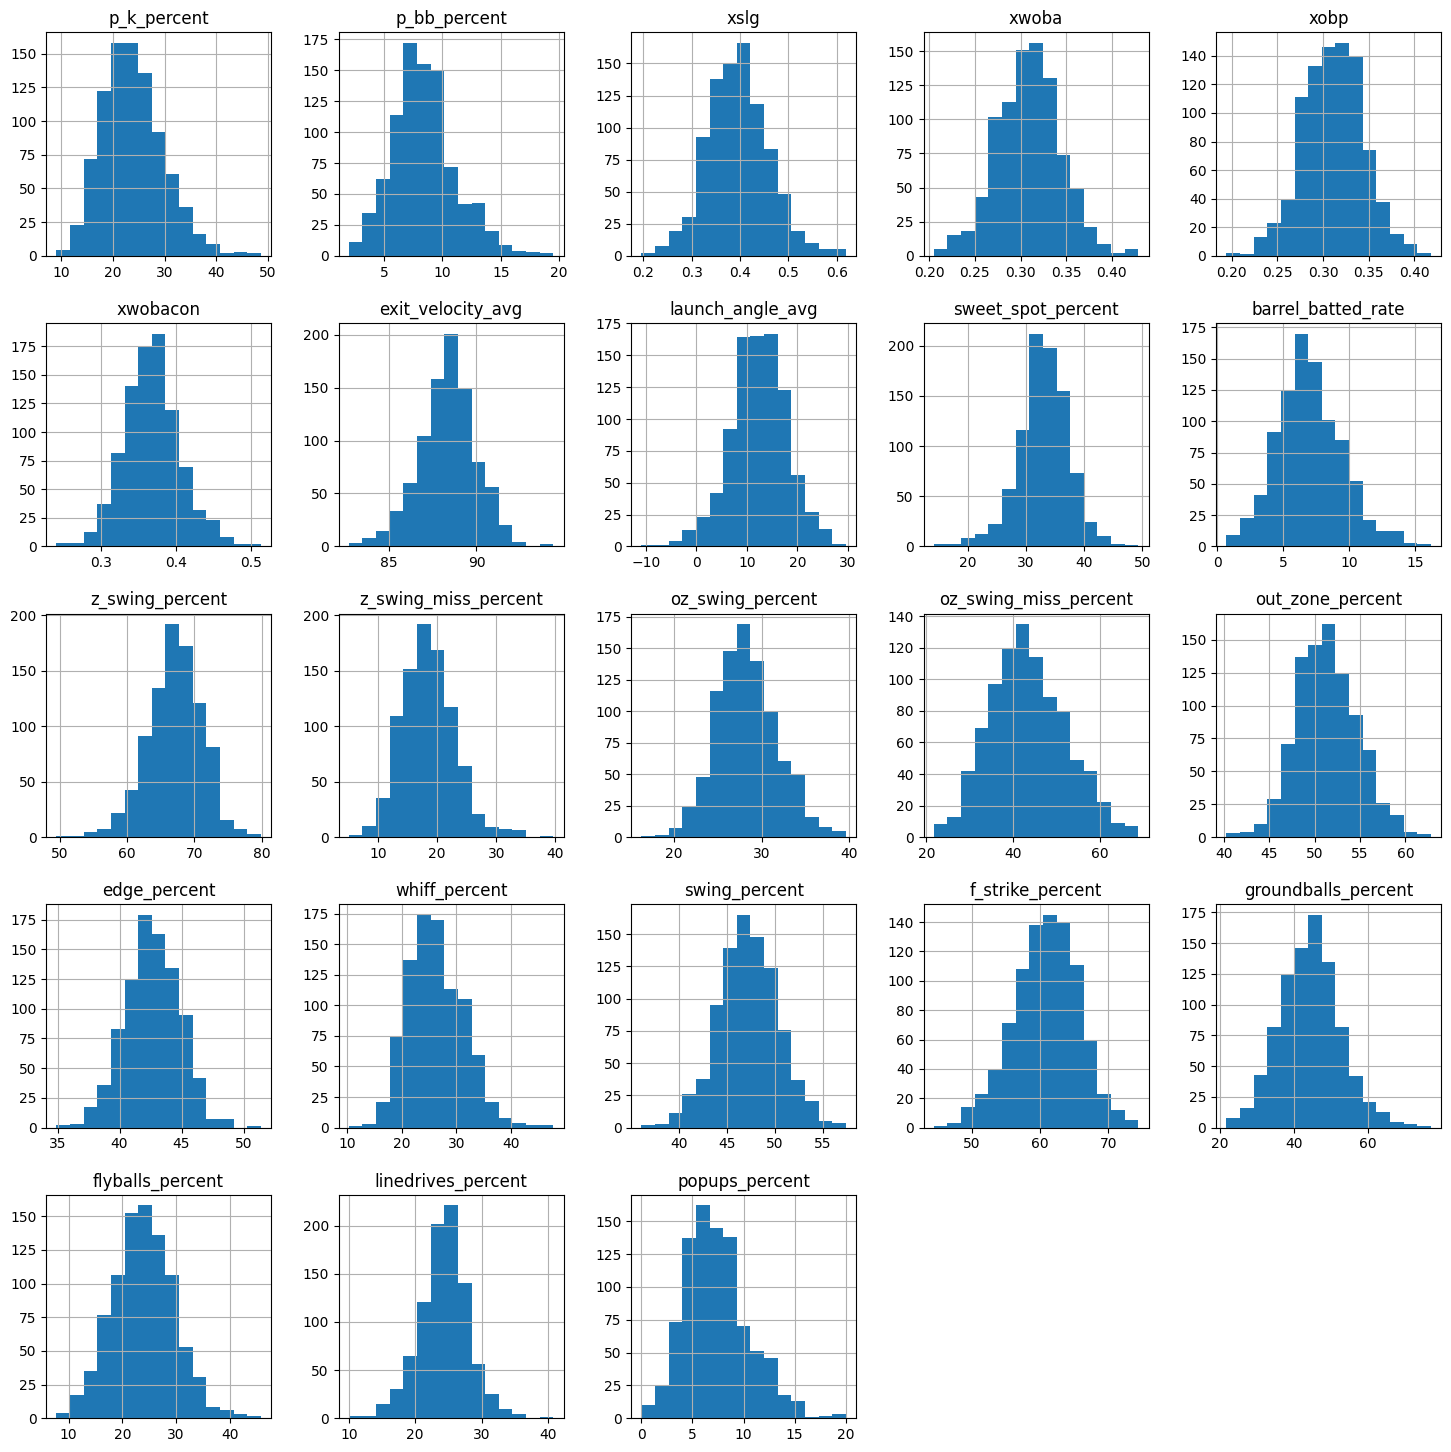

In [11]:
## Examining histograms and distributions of features
plt.rcParams.update({'font.size': 10})
X_train.hist(bins = 15, figsize = (18,18))

All features besides saves appear to be normally distributed, which is to be expected with metrics. There appears to be a slightly larger right-tail on many of the histograms, indicating that the most prolific pitchers in certain metrics deviate further from the mean than the least prolific pitchers for said metric. 

In [12]:
## Preprocessing
colnames = list(X_train.columns)
## setting category names for preprocessor
scaling_feats = colnames
colnames

['p_k_percent',
 'p_bb_percent',
 'xslg',
 'xwoba',
 'xobp',
 'xwobacon',
 'exit_velocity_avg',
 'launch_angle_avg',
 'sweet_spot_percent',
 'barrel_batted_rate',
 'z_swing_percent',
 'z_swing_miss_percent',
 'oz_swing_percent',
 'oz_swing_miss_percent',
 'out_zone_percent',
 'edge_percent',
 'whiff_percent',
 'swing_percent',
 'f_strike_percent',
 'groundballs_percent',
 'flyballs_percent',
 'linedrives_percent',
 'popups_percent']

In [13]:
## Creating column transformer
ct = make_column_transformer(
    (StandardScaler(), scaling_feats))

ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['p_k_percent', 'p_bb_percent', 'xslg',
                                  'xwoba', 'xobp', 'xwobacon',
                                  'exit_velocity_avg', 'launch_angle_avg',
                                  'sweet_spot_percent', 'barrel_batted_rate',
                                  'z_swing_percent', 'z_swing_miss_percent',
                                  'oz_swing_percent', 'oz_swing_miss_percent',
                                  'out_zone_percent', 'edge_percent',
                                  'whiff_percent', 'swing_percent',
                                  'f_strike_percent', 'groundballs_percent',
                                  'flyballs_percent', 'linedrives_percent',
                                  'popups_percent'])])

In [14]:
# Fitting X_train with scaled values, transforming both X_train and X_test
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)

In [15]:
## Creating transformed data frames
X_train_transformed = pd.DataFrame(transformed_X_train, columns = colnames)
X_test_transformed = pd.DataFrame(transformed_X_test, columns = colnames)
X_train_transformed.head()

p_k_percent  p_bb_percent      xslg     xwoba      xobp  xwobacon  \
0    -1.037467     -0.159966  0.998005  1.345256  1.512573  1.074299   
1    -0.646599      0.315028 -0.428688 -0.084098  0.096173 -0.948597   
2    -0.068794      0.461180  0.433599  0.316121  0.005764  0.249170   
3    -0.323708      0.534256  0.214107  0.487643  0.729033  0.302404   
4    -0.884518      0.315028  0.073006  0.144598  0.337262 -0.575959   

   exit_velocity_avg  launch_angle_avg  sweet_spot_percent  \
0           0.280416         -1.018639            0.328637   
1          -1.595086         -0.102009           -0.021738   
2           0.342933          1.174084           -0.605698   
3          -1.032436          0.940433            1.893648   
4           0.843067         -1.989188           -1.820333   

   barrel_batted_rate  ...  oz_swing_miss_percent  out_zone_percent  \
0           -0.015213  ...              -0.258607          1.432317   
1           -0.258073  ...              -1.659647         -0.662728   
2            0.753844  ...               0.545269          1.133025   
3           -0.298549  ...              -1.785971         -1.440887   
4           -0.096166  ...              -1.165838          2.569627   

   edge_percent  whiff_percent  swing_percent  f_strike_percent  \
0      1.634485      -0.569977      -0.420331         -0.710952   
1     -0.721826      -1.731984      -0.896037         -0.345966   
2     -0.903080       0.165961      -0.674041         -0.990060   
3      1.317290       0.146594      -0.769182         -0.045389   
4      1.271976      -0.724911       0.087089         -0.174208   

   groundballs_percent  flyballs_percent  linedrives_percent  popups_percent  
0             0.867425         -1.842191            1.876523       -1.103498  
1            -0.010643         -0.316062            0.744840       -0.304587  
2            -0.924795          0.793850           -0.252118        1.293235  
3            -1.417956          0.048128            1.660964        1.676712  
4             1.901861         -1.460659           -0.791014       -1.423062  

[5 rows x 23 columns]

### Dummy Regressor

In [16]:
## Creating function that returns mean and sd of cv scores
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [17]:
## Performing regression with dummy regressor
s = "neg_mean_absolute_percentage_error"
results = {}
dc = DummyRegressor(strategy = "mean")
pipe = make_pipeline(ct, dc)
dc.fit(X_train, y_train)
results["dummy"] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score = True, 
                                             scoring=s)
pd.DataFrame(results)

dummy
fit_time      0.003 (+/- 0.000)
score_time    0.001 (+/- 0.000)
test_score   -0.569 (+/- 0.089)
train_score  -0.568 (+/- 0.020)

Dummy regressor is quite inaccurate with its predictions with a MAPE of 0.569 for the test set. 

### Ridge

In [18]:
pipe_linear_test = make_pipeline(ct, Ridge())

In [19]:
## Performing hyperparameter optimization for alpha in ridge
param_grid_linear = {"ridge__alpha" : [0.001,0.01,0.1,1,10,100,1000]}
random_search_linear = RandomizedSearchCV(pipe_linear_test, param_grid_linear, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring=s)
random_search_linear.fit(X_train, y_train)
results_lin = pd.DataFrame(random_search_linear.cv_results_).set_index("rank_test_score").sort_index()
results_lin.T

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


rank_test_score                         1                     2  \
mean_fit_time                    0.004934              0.003735   
std_fit_time                     0.002099              0.000333   
mean_score_time                  0.001715              0.002072   
std_score_time                   0.000144              0.000776   
param_ridge__alpha                    100                    10   
params              {'ridge__alpha': 100}  {'ridge__alpha': 10}   
split0_test_score               -0.638918             -0.642053   
split1_test_score               -0.406383             -0.404614   
split2_test_score               -0.442201             -0.442141   
split3_test_score               -0.518323             -0.516155   
split4_test_score               -0.478691             -0.480232   
mean_test_score                 -0.496903             -0.497039   
std_test_score                   0.080181              0.081527   

rank_test_score                       3                      4  \
mean_fit_time                  0.004939               0.005696   
std_fit_time                   0.002002               0.002505   
mean_score_time                0.001781               0.001685   
std_score_time                 0.000135               0.000227   
param_ridge__alpha                    1                    0.1   
params              {'ridge__alpha': 1}  {'ridge__alpha': 0.1}   
split0_test_score             -0.645183              -0.647463   
split1_test_score             -0.403839              -0.403428   
split2_test_score             -0.440004              -0.438875   
split3_test_score             -0.517217              -0.517803   
split4_test_score             -0.483831              -0.485481   
mean_test_score               -0.498015               -0.49861   
std_test_score                 0.083022               0.084055   

rank_test_score                          5                        6  \
mean_fit_time                     0.008527                 0.010042   
std_fit_time                      0.005763                 0.002951   
mean_score_time                   0.004222                 0.002651   
std_score_time                    0.002686                 0.001039   
param_ridge__alpha                    0.01                    0.001   
params              {'ridge__alpha': 0.01}  {'ridge__alpha': 0.001}   
split0_test_score                -0.648773                -0.649125   
split1_test_score                 -0.40337                -0.403365   
split2_test_score                -0.439065                -0.439184   
split3_test_score                -0.518119                -0.518332   
split4_test_score                -0.485836                -0.485905   
mean_test_score                  -0.499032                -0.499182   
std_test_score                    0.084508                 0.084625   

rank_test_score                          7  
mean_fit_time                     0.004091  
std_fit_time                      0.000726  
mean_score_time                   0.001504  
std_score_time                    0.000074  
param_ridge__alpha                    1000  
params              {'ridge__alpha': 1000}  
split0_test_score                -0.646291  
split1_test_score                -0.422247  
split2_test_score                -0.447615  
split3_test_score                -0.539088  
split4_test_score                -0.485138  
mean_test_score                  -0.508076  
std_test_score                    0.079516

In [20]:
## Applying ridge model with alpha = 100
pipe_linear = make_pipeline(ct, Ridge(alpha = 100))
results["linear"] = mean_std_cross_val_scores(pipe_linear, X_train, y_train, return_train_score = True, scoring = "neg_mean_absolute_percentage_error")
pd.DataFrame(results)

dummy              linear
fit_time      0.003 (+/- 0.000)   0.005 (+/- 0.002)
score_time    0.001 (+/- 0.000)   0.003 (+/- 0.003)
test_score   -0.569 (+/- 0.089)  -0.497 (+/- 0.090)
train_score  -0.568 (+/- 0.020)  -0.486 (+/- 0.020)

Ridge performs better than dummy regressor, and has okay accuracy with a 0.498 MAPE. 

## Gradient Boosted Models

In [21]:
## Creating pipelines for the three models
pipe_rf = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1))
pipe_xg = make_pipeline(ct, XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0))
pipe_cat = make_pipeline(ct, CatBoostRegressor(verbose=0, random_state=123))


In [22]:
## Hyperparameter optimization for random forest regressor
param_grid_rf = {"randomforestregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "randomforestregressor__n_estimators" : [2,4,6,8,10,12,14,16,18,20]}
random_search_rf = RandomizedSearchCV(pipe_rf, param_grid_rf, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = s)
random_search_rf.fit(X_train, y_train)
results_rf = pd.DataFrame(random_search_rf.cv_results_).set_index("rank_test_score").sort_index()
results_rf.T

rank_test_score                                                                          1    \
mean_fit_time                                                                       0.115114   
std_fit_time                                                                        0.042821   
mean_score_time                                                                     0.045533   
std_score_time                                                                      0.010188   
param_randomforestregressor__n_estimators                                                 20   
param_randomforestregressor__max_depth                                                    12   
params                                     {'randomforestregressor__n_estimators': 20, 'r...   
split0_test_score                                                                  -0.635141   
split1_test_score                                                                  -0.393815   
split2_test_score                                                                   -0.47815   
split3_test_score                                                                  -0.509093   
split4_test_score                                                                  -0.474981   
mean_test_score                                                                    -0.498236   
std_test_score                                                                      0.078369   

rank_test_score                                                                          2    \
mean_fit_time                                                                       0.140329   
std_fit_time                                                                        0.031083   
mean_score_time                                                                     0.028688   
std_score_time                                                                      0.011312   
param_randomforestregressor__n_estimators                                                 20   
param_randomforestregressor__max_depth                                                    14   
params                                     {'randomforestregressor__n_estimators': 20, 'r...   
split0_test_score                                                                   -0.63646   
split1_test_score                                                                  -0.396405   
split2_test_score                                                                  -0.483992   
split3_test_score                                                                  -0.507996   
split4_test_score                                                                   -0.47246   
mean_test_score                                                                    -0.499463   
std_test_score                                                                      0.078013   

rank_test_score                                                                          3    \
mean_fit_time                                                                        0.14341   
std_fit_time                                                                        0.041206   
mean_score_time                                                                     0.042794   
std_score_time                                                                      0.021801   
param_randomforestregressor__n_estimators                                                 16   
param_randomforestregressor__max_depth                                                    12   
params                                     {'randomforestregressor__n_estimators': 16, 'r...   
split0_test_score                                                                  -0.631547   
split1_test_score                                                                  -0.390333   
split2_test_score                                                                  -0.483159   
split3_test_score                                             

In [23]:
results_rf.T.iloc[6][1]

{'randomforestregressor__n_estimators': 20,
 'randomforestregressor__max_depth': 12}

Best parameter for random forest are n_estimators = 20 and max_depth = 12

In [24]:
pipe_rf1 = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1, n_estimators = 20, max_depth = 12))
results["Random Forest"] = mean_std_cross_val_scores(pipe_rf1, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)

dummy              linear       Random Forest
fit_time      0.003 (+/- 0.000)   0.005 (+/- 0.002)   0.072 (+/- 0.050)
score_time    0.001 (+/- 0.000)   0.003 (+/- 0.003)   0.005 (+/- 0.001)
test_score   -0.569 (+/- 0.089)  -0.497 (+/- 0.090)  -0.498 (+/- 0.088)
train_score  -0.568 (+/- 0.020)  -0.486 (+/- 0.020)  -0.213 (+/- 0.006)

Random forest performs ever so slightly worse than Ridge regression, however the large amount of overfitting that occurs with random forest nullifies this performance. 

In [25]:
## hyperparameter optimization for XGBoost
param_grid_xgb = {"xgbregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "xgbregressor__learning_rate" : [0.001,0.01,0.1,0.2,0.3,0.4]}
random_search_xgb = RandomizedSearchCV(pipe_xg, param_grid_xgb, n_iter = 40, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = s)
random_search_xgb.fit(X_train, y_train)
results_xgb = pd.DataFrame(random_search_xgb.cv_results_).set_index("rank_test_score").sort_index()
results_xgb.T

rank_test_score                                                                   1   \
mean_fit_time                                                               0.276127   
std_fit_time                                                                0.013794   
mean_score_time                                                             0.002704   
std_score_time                                                              0.000098   
param_xgbregressor__max_depth                                                      6   
param_xgbregressor__learning_rate                                               0.01   
params                             {'xgbregressor__max_depth': 6, 'xgbregressor__...   
split0_test_score                                                          -0.575826   
split1_test_score                                                          -0.366372   
split2_test_score                                                          -0.486469   
split3_test_score                                                           -0.49455   
split4_test_score                                                          -0.503259   
mean_test_score                                                            -0.485295   
std_test_score                                                              0.067451   

rank_test_score                                                                   2   \
mean_fit_time                                                               0.097854   
std_fit_time                                                                 0.00809   
mean_score_time                                                             0.005499   
std_score_time                                                              0.003648   
param_xgbregressor__max_depth                                                      2   
param_xgbregressor__learning_rate                                               0.01   
params                             {'xgbregressor__max_depth': 2, 'xgbregressor__...   
split0_test_score                                                          -0.589267   
split1_test_score                                                           -0.37477   
split2_test_score                                                          -0.483913   
split3_test_score                                                          -0.490369   
split4_test_score                                                          -0.494299   
mean_test_score                                                            -0.486524   
std_test_score                                                               0.06801   

rank_test_score                                                                   3   \
mean_fit_time                                                               0.191849   
std_fit_time                                                                0.005955   
mean_score_time                                                             0.003415   
std_score_time                                                              0.001776   
param_xgbregressor__max_depth                                                      4   
param_xgbregressor__learning_rate                                               0.01   
params                             {'xgbregressor__max_depth': 4, 'xgbregressor__...   
split0_test_score                                                          -0.586564   
split1_test_score                                                           -0.37576   
split2_test_score                                                          -0.488721   
split3_test_score                                                          -0.487634   
split4_test_score                                                          -0.495416   
mean_test_score                                                            -0.486819   
std_test_score                                                              0.066875   

rank_test_score                      

In [26]:
results_xgb.T.iloc[6][1]

{'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.01}

Best parameters for XGBoost are max_depth = 6 and learning_rate = 0.01

In [27]:
pipe_xgb = make_pipeline(ct, XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0
                                        , max_depth = 6, learning_rate = 0.01))
results["XGB"] = mean_std_cross_val_scores(pipe_xgb, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)

dummy              linear       Random Forest  \
fit_time      0.003 (+/- 0.000)   0.005 (+/- 0.002)   0.072 (+/- 0.050)   
score_time    0.001 (+/- 0.000)   0.003 (+/- 0.003)   0.005 (+/- 0.001)   
test_score   -0.569 (+/- 0.089)  -0.497 (+/- 0.090)  -0.498 (+/- 0.088)   
train_score  -0.568 (+/- 0.020)  -0.486 (+/- 0.020)  -0.213 (+/- 0.006)   

                            XGB  
fit_time      0.125 (+/- 0.030)  
score_time    0.003 (+/- 0.001)  
test_score   -0.485 (+/- 0.075)  
train_score  -0.370 (+/- 0.012)

XGBoost performs better than all of the previous models, however the overfitting from XGBoost is not worth the 0.012 difference in MAPE from the Ridge model. 

In [28]:
# Hyperparameter optimization for CatBoost
param_grid_cat = {"catboostregressor__learning_rate" : [0.001,0.01,0.1,0.2],
                  "catboostregressor__n_estimators" : [10,50,100,200,300]}
random_search_cat = RandomizedSearchCV(pipe_cat, param_grid_cat, n_iter = 20, cv = 5, n_jobs = -1, random_state = 123,
                                      scoring = s)
random_search_cat.fit(X_train, y_train)
results_cat = pd.DataFrame(random_search_cat.cv_results_).set_index("rank_test_score").sort_index()
results_cat.T

rank_test_score                                                                        1   \
mean_fit_time                                                                    0.597546   
std_fit_time                                                                     0.079995   
mean_score_time                                                                  0.005112   
std_score_time                                                                    0.00096   
param_catboostregressor__n_estimators                                                 100   
param_catboostregressor__learning_rate                                                0.1   
params                                  {'catboostregressor__n_estimators': 100, 'catb...   
split0_test_score                                                               -0.641128   
split1_test_score                                                               -0.401462   
split2_test_score                                                               -0.474458   
split3_test_score                                                               -0.521605   
split4_test_score                                                               -0.493409   
mean_test_score                                                                 -0.506412   
std_test_score                                                                    0.07821   

rank_test_score                                                                        2   \
mean_fit_time                                                                    1.153772   
std_fit_time                                                                     0.087801   
mean_score_time                                                                  0.005184   
std_score_time                                                                   0.001048   
param_catboostregressor__n_estimators                                                 200   
param_catboostregressor__learning_rate                                                0.1   
params                                  {'catboostregressor__n_estimators': 200, 'catb...   
split0_test_score                                                               -0.654003   
split1_test_score                                                               -0.393561   
split2_test_score                                                               -0.479428   
split3_test_score                                                               -0.520636   
split4_test_score                                                               -0.486971   
mean_test_score                                                                  -0.50692   
std_test_score                                                                   0.084647   

rank_test_score                                                                        3   \
mean_fit_time                                                                    1.816212   
std_fit_time                                                                     0.150331   
mean_score_time                                                                  0.004626   
std_score_time                                                                   0.000958   
param_catboostregressor__n_estimators                                                 300   
param_catboostregressor__learning_rate                                                0.1   
params                                  {'catboostregressor__n_estimators': 300, 'catb...   
split0_test_score                                                               -0.660741   
split1_test_score                                                               -0.388223   
split2_test_score                                                               -0.481967   
split3_test_score                                                               -0.524819   
split4_test_score                                                               -0.482834   

In [29]:
results_cat.T.iloc[6][1]

{'catboostregressor__n_estimators': 100,
 'catboostregressor__learning_rate': 0.1}

Best parameters for CatBoost are n_estimators = 100 and learning_rate = 0.1

In [30]:
pipe_catb = make_pipeline(ct, CatBoostRegressor(verbose=0, random_state=123, n_estimators = 100, learning_rate = 0.1))
results["CatBoost"] = mean_std_cross_val_scores(pipe_catb, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)   

dummy              linear       Random Forest  \
fit_time      0.003 (+/- 0.000)   0.005 (+/- 0.002)   0.072 (+/- 0.050)   
score_time    0.001 (+/- 0.000)   0.003 (+/- 0.003)   0.005 (+/- 0.001)   
test_score   -0.569 (+/- 0.089)  -0.497 (+/- 0.090)  -0.498 (+/- 0.088)   
train_score  -0.568 (+/- 0.020)  -0.486 (+/- 0.020)  -0.213 (+/- 0.006)   

                            XGB            CatBoost  
fit_time      0.125 (+/- 0.030)   0.144 (+/- 0.003)  
score_time    0.003 (+/- 0.001)   0.003 (+/- 0.001)  
test_score   -0.485 (+/- 0.075)  -0.506 (+/- 0.087)  
train_score  -0.370 (+/- 0.012)  -0.329 (+/- 0.012)

Catboost performs worse than the previous models on the test data with overfitting. 

### Feature Selection

In [31]:
# performing forward selection with Ridge to see if model accuracy can be improved
pipe_forward_ridge = make_pipeline(
    ct,
    SequentialFeatureSelector(Ridge(alpha = 100), 
                              direction="forward", 
                              n_features_to_select='auto', 
                              tol=None),
    Ridge(alpha = 10),
)

In [32]:
results["Ridgeselected"] = mean_std_cross_val_scores(pipe_forward_ridge, X_train, y_train, return_train_score = True,
                                                    scoring = s)
pd.DataFrame(results)

dummy              linear       Random Forest  \
fit_time      0.003 (+/- 0.000)   0.005 (+/- 0.002)   0.072 (+/- 0.050)   
score_time    0.001 (+/- 0.000)   0.003 (+/- 0.003)   0.005 (+/- 0.001)   
test_score   -0.569 (+/- 0.089)  -0.497 (+/- 0.090)  -0.498 (+/- 0.088)   
train_score  -0.568 (+/- 0.020)  -0.486 (+/- 0.020)  -0.213 (+/- 0.006)   

                            XGB            CatBoost       Ridgeselected  
fit_time      0.125 (+/- 0.030)   0.144 (+/- 0.003)   0.835 (+/- 0.013)  
score_time    0.003 (+/- 0.001)   0.003 (+/- 0.001)   0.001 (+/- 0.000)  
test_score   -0.485 (+/- 0.075)  -0.506 (+/- 0.087)  -0.496 (+/- 0.091)  
train_score  -0.370 (+/- 0.012)  -0.329 (+/- 0.012)  -0.485 (+/- 0.021)

Feature selection does improve the model by 0.001 MAPE, however I would like to keep all of the features in the model rather than improve by this small of an amount. This allows for the examination of feature importances to develop an intuition on which characteristics of pitchers correlate to the best fantasy performers. 

### Feature Importances

In [33]:
pipe_opt = make_pipeline(ct, Ridge(alpha = 100))

In [34]:
pipe_opt.fit(X_train, y_train)
pipe_opt.named_steps
coeffs = pipe_opt.named_steps["ridge"].coef_
coeffs

array([ 0.11737548,  0.00412536, -0.03364375, -0.01260954, -0.03686563,
        0.05534014, -0.03568597, -0.01368332, -0.03638556,  0.00490668,
       -0.02379094,  0.07320581,  0.02543847,  0.04485874, -0.06894249,
       -0.01054044,  0.05580384,  0.01676654,  0.00430171, -0.00730398,
        0.02352594,  0.00602221, -0.0306916 ])

In [35]:
pd.DataFrame(data=coeffs, index=X_train_transformed.columns, columns=["Coefficients"]).sort_values(by = "Coefficients")

Coefficients
out_zone_percent          -0.068942
xobp                      -0.036866
sweet_spot_percent        -0.036386
exit_velocity_avg         -0.035686
xslg                      -0.033644
popups_percent            -0.030692
z_swing_percent           -0.023791
launch_angle_avg          -0.013683
xwoba                     -0.012610
edge_percent              -0.010540
groundballs_percent       -0.007304
p_bb_percent               0.004125
f_strike_percent           0.004302
barrel_batted_rate         0.004907
linedrives_percent         0.006022
swing_percent              0.016767
flyballs_percent           0.023526
oz_swing_percent           0.025438
oz_swing_miss_percent      0.044859
xwobacon                   0.055340
whiff_percent              0.055804
z_swing_miss_percent       0.073206
p_k_percent                0.117375

From the coefficients above we can see that strikeout percent overwhelmingly have the highest feature importance. This is due to large impact that strikeouts have on fantasy points, making swing and miss pitchers far more valuable. Other swing and miss metrics are very high up on the feature importances list, once again emphasizing the importance of strikeouts. The features with negative feature importances are golf style metrics (Rather have a lower score), which indicates a positive correlation to having a "better" value for this metric. 

In [36]:
pipe_opt.named_steps["ridge"].intercept_

1.7142722063347435

This intercept is approximately the average fantasy points per inning. This indicates that the model begins at "average", and will deviate from this average based on the metrics provided. 

### Test Set

In [37]:
pipe_opt.fit(X_train, y_train)
test_predict = pipe_opt.predict(X_test)
test_score = mean_absolute_percentage_error(y_test, pipe_opt.predict(X_test))
test_score

0.566791143184182

The test set has a MAPE of 0.528.. not bad. The true predictions will be looked at to determine if they are accurate or not. 

In [38]:
## Adding predictionns into dataset
y_test_df = pd.DataFrame(y_test)
y_test_df["Fpointsper"] = test_predict.tolist()
y_test_df

Fpointsper
player                       
Matz, Steven         1.732440
Maton III, Phil      1.898853
Eflin, Zach          1.425020
Leclerc, Jose        2.464087
Turnbull, Spencer    1.519229
...                       ...
Morton, Charlie      1.881621
Junis, Jakob         1.582708
Norris, Daniel       1.563552
Giolito, Lucas       1.304610
Boyd, Matthew        1.636753

[224 rows x 1 columns]

In [39]:
y_test_df['rank'] = y_test_df['Fpointsper'].rank(ascending=False)
y_test_df.sort_values(by = "rank", ascending = True).head(20)

Fpointsper  rank
player                            
Williams, Devin     3.259179   1.0
deGrom, Jacob       2.778506   2.0
Kimbrel, Craig      2.595181   3.0
Chapman, Aroldis    2.510447   4.0
Leclerc, Jose       2.464087   5.0
Kopech, Michael     2.386149   6.0
Springs, Jeffrey    2.350533   7.0
Rogers, Taylor      2.314485   8.0
Diaz, Edwin O       2.265864   9.0
Rodon, Carlos       2.254431  10.0
Gausman, Kevin      2.237151  11.0
Paxton, James       2.215182  12.0
Pressly, Ryan       2.213942  13.0
Romano, Jordan      2.181198  14.0
Fairbanks, Pete     2.161786  15.0
Alvarado, Jose      2.161016  16.0
Snell, Blake        2.133206  17.0
Neris, Hector       2.118516  18.0
Green, Chad         2.102784  19.0
Stratton, Chris     2.069667  20.0

The predictions do seem to coincide with elite fantasy pitchers, as the top 20 include many of the greatest high-strikeout relievers and starters we have seen in the MLB over the last 5 seasons. 

## 2023 Predictions

In [40]:
newdata = pd.read_csv("data/Pitch2022_c.csv")
newdata.head()

player  year  p_k_percent  p_bb_percent  p_save   xslg  xwoba  \
0   Wainwright, Adam  2022         17.8           6.7       0  0.419  0.328   
1      Greinke, Zack  2022         12.5           4.6       0  0.441  0.336   
2  Verlander, Justin  2022         27.8           4.4       0  0.331  0.255   
3    Sanchez, Anibal  2022         16.4          11.3       0  0.411  0.332   
4     Jansen, Kenley  2022         32.7           8.5      41  0.292  0.239   

    xobp  xwobacon  exit_velocity_avg  ...  oz_swing_miss_percent  \
0  0.326     0.370               87.8  ...                   31.5   
1  0.322     0.365               88.9  ...                   27.7   
2  0.248     0.327               87.8  ...                   38.0   
3  0.344     0.348               88.5  ...                   29.9   
4  0.247     0.311               87.1  ...                   40.8   

   out_zone_percent  edge_percent  whiff_percent  swing_percent  \
0              50.2          44.3           16.9           43.5   
1              52.6          43.3           17.3           46.2   
2              48.9          46.1           24.2           53.7   
3              55.3          42.0           19.5           45.0   
4              44.2          45.0           27.3           50.6   

   f_strike_percent  groundballs_percent  flyballs_percent  \
0              62.6                 43.7              25.2   
1              64.8                 41.5              23.2   
2              62.0                 38.6              28.5   
3              57.4                 39.1              30.9   
4              68.7                 30.5              39.1   

   linedrives_percent  popups_percent  
0                26.5             4.5  
1                28.2             7.1  
2                21.1            11.9  
3                21.3             8.7  
4                18.5            11.9  

[5 rows x 26 columns]

In [41]:
preds = pipe_opt.predict(newdata)

In [42]:
newdata["prediction"] = preds.tolist()
newdata['rank'] = newdata['prediction'].rank(ascending = False)
newsorted = newdata.sort_values(by = "rank", ascending = True)
newsorted[["player", "prediction", "rank"]].head(10)

player  prediction  rank
261   Strider, Spencer    2.489281   1.0
199       Duran, Jhoan    2.435677   2.0
56      Heaney, Andrew    2.335301   3.0
196     Ohtani, Shohei    2.310168   4.0
167    Bautista, Felix    2.300048   5.0
212    Stephan, Trevor    2.284714   6.0
200    Clase, Emmanuel    2.281769   7.0
206  McClanahan, Shane    2.281574   8.0
132       Minter, A.J.    2.268999   9.0
4       Jansen, Kenley    2.240129  10.0

In [43]:
## Adding IP, W, L, S, H
ip_data = pd.read_csv("data/PitchRazz_S.csv")
ip_data.head()

player     IP     W    L  SV  HLD
0  Alcantara, Sandy  200.2  13.8  8.9   0    0
1   Valdez, Framber  194.0  15.0  6.7   0    0
2       Nola, Aaron  191.0  13.4  8.0   0    0
3        Fried, Max  191.0  14.3  7.2   0    0
4    Burnes, Corbin  191.0  13.4  7.7   0    0

In [44]:
full_data = newdata.merge(ip_data, left_on = "player", right_on = 'player')
full_data.head()

player  year  p_k_percent  p_bb_percent  p_save   xslg  xwoba  \
0   Wainwright, Adam  2022         17.8           6.7       0  0.419  0.328   
1      Greinke, Zack  2022         12.5           4.6       0  0.441  0.336   
2  Verlander, Justin  2022         27.8           4.4       0  0.331  0.255   
3    Sanchez, Anibal  2022         16.4          11.3       0  0.411  0.332   
4     Jansen, Kenley  2022         32.7           8.5      41  0.292  0.239   

    xobp  xwobacon  exit_velocity_avg  ...  flyballs_percent  \
0  0.326     0.370               87.8  ...              25.2   
1  0.322     0.365               88.9  ...              23.2   
2  0.248     0.327               87.8  ...              28.5   
3  0.344     0.348               88.5  ...              30.9   
4  0.247     0.311               87.1  ...              39.1   

   linedrives_percent  popups_percent  prediction   rank     IP     W    L  \
0                26.5             4.5    1.292482  245.0  172.8  11.5  8.8   
1                28.2             7.1    1.130939  267.0  138.9   7.4  8.7   
2                21.1            11.9    1.833105   76.0  172.0  12.6  6.5   
3                21.3             8.7    1.167523  262.0   81.0   4.2  5.4   
4                18.5            11.9    2.240129   10.0   64.8   3.3  3.1   

   SV  HLD  
0   0    0  
1   0    0  
2   0    0  
3   0    0  
4  25    3  

[5 rows x 33 columns]

In [45]:
## Fpoints = pred * IP + (2*Wins - 2*Losses + 5*Saves + 2*Holds)
full_data["Fpoints"] = full_data['prediction'] * full_data['IP'] + (2*full_data['W'] - 2 *full_data['L'] + 5*full_data['SV'] + 2*full_data["HLD"])
full_data.head()

player  year  p_k_percent  p_bb_percent  p_save   xslg  xwoba  \
0   Wainwright, Adam  2022         17.8           6.7       0  0.419  0.328   
1      Greinke, Zack  2022         12.5           4.6       0  0.441  0.336   
2  Verlander, Justin  2022         27.8           4.4       0  0.331  0.255   
3    Sanchez, Anibal  2022         16.4          11.3       0  0.411  0.332   
4     Jansen, Kenley  2022         32.7           8.5      41  0.292  0.239   

    xobp  xwobacon  exit_velocity_avg  ...  linedrives_percent  \
0  0.326     0.370               87.8  ...                26.5   
1  0.322     0.365               88.9  ...                28.2   
2  0.248     0.327               87.8  ...                21.1   
3  0.344     0.348               88.5  ...                21.3   
4  0.247     0.311               87.1  ...                18.5   

   popups_percent  prediction   rank     IP     W    L  SV  HLD     Fpoints  
0             4.5    1.292482  245.0  172.8  11.5  8.8   0    0  228.740942  
1             7.1    1.130939  267.0  138.9   7.4  8.7   0    0  154.487373  
2            11.9    1.833105   76.0  172.0  12.6  6.5   0    0  327.493983  
3             8.7    1.167523  262.0   81.0   4.2  5.4   0    0   92.169334  
4            11.9    2.240129   10.0   64.8   3.3  3.1  25    3  276.560362  

[5 rows x 34 columns]

In [46]:
full_data['rank'] = full_data['Fpoints'].rank(ascending = False)
full_data.sort_values(by = "rank").head(15)

player  year  p_k_percent  p_bb_percent  p_save   xslg  xwoba  \
43        Cole, Gerrit  2022         32.4           6.3       0  0.383  0.284   
256   Strider, Spencer  2022         38.3           8.5       0  0.279  0.242   
233     Burnes, Corbin  2022         30.5           6.4       0  0.337  0.273   
101        Nola, Aaron  2022         29.1           3.6       0  0.340  0.259   
202  McClanahan, Shane  2022         30.3           5.9       0  0.332  0.261   
192     Ohtani, Shohei  2022         33.2           6.7       0  0.311  0.256   
106  Woodruff, Brandon  2022         30.6           6.8       0  0.349  0.277   
172   Alcantara, Sandy  2022         23.4           5.6       0  0.331  0.267   
29         Darvish, Yu  2022         25.6           4.8       0  0.388  0.291   
176       Cease, Dylan  2022         30.4          10.4       0  0.292  0.257   
109      Rodon, Carlos  2022         33.4           7.3       0  0.309  0.254   
9        Scherzer, Max  2022         30.6           4.2       0  0.339  0.265   
211    Valdez, Framber  2022         23.5           8.1       0  0.330  0.284   
135     Castillo, Luis  2022         27.2           7.3       0  0.344  0.284   
242      Bieber, Shane  2022         25.0           4.6       0  0.386  0.292   

      xobp  xwobacon  exit_velocity_avg  ...  linedrives_percent  \
43   0.266     0.394               89.4  ...                22.2   
256  0.254     0.343               88.0  ...                26.3   
233  0.275     0.354               87.2  ...                21.8   
101  0.248     0.343               87.7  ...                24.2   
202  0.257     0.345               87.6  ...                23.2   
192  0.260     0.347               87.1  ...                22.8   
106  0.273     0.365               88.8  ...                22.8   
172  0.268     0.316               87.8  ...                18.9   
29   0.275     0.363               88.5  ...                21.9   
176  0.273     0.313               86.8  ...                22.1   
109  0.260     0.341               89.0  ...                25.4   
9    0.253     0.352               87.8  ...                22.7   
211  0.301     0.327               89.8  ...                19.5   
135  0.291     0.350               89.0  ...                24.9   
242  0.281     0.369               89.9  ...                24.3   

     popups_percent  prediction  rank     IP     W    L  SV  HLD     Fpoints  
43              7.2    2.207864   1.0  187.9  13.5  7.2   0    0  427.457627  
256             7.6    2.489281   2.0  160.9  11.5  5.7   0    0  412.125309  
233             6.3    2.074255   3.0  191.0  13.4  7.7   0    0  407.582738  
101             7.3    2.074739   4.0  191.0  13.4  8.0   0    0  407.075066  
202             5.2    2.281574   5.0  172.3  12.2  6.6   0    0  404.315252  
192             8.6    2.310168   6.0  165.0  11.9  6.2   0    0  392.577740  
106             8.7    2.132714   7.0  178.6  11.8  8.0   0    0  388.502764  
172             7.1    1.846657   8.0  200.2  13.8  8.9   0    0  379.500678  
29              8.6    1.970820   9.0  184.8  14.1  7.0   0    0  378.407492  
176             8.2    2.047427  10.0  178.6  11.8  8.1   0    0  373.070517  
109             9.8    2.166627  11.0  166.4  11.6  6.4   0    0  370.926699  
9              13.4    2.124688  12.0  167.8  12.4  6.3   0    0  368.722668  
211             2.5    1.810583  13.0  194.0  15.0  6.7   0    0  367.853132  
135             6.3    1.917778  14.0  184.8  12.8  7.9   0    0  364.205328  
242             5.9    1.912975  15.0  184.8  12.7  8.0   0    0  362.917711  

[15 rows x 34 columns]

In [47]:
teams = pd.read_csv("data/PitchTeam.csv")
teams.head()

player Team
0  Almonte, Yency  LAD
1  Phillips, Evan  LAD
2    Stanek, Ryne  HOU
3   Helsley, Ryan  STL
4     Diaz, Edwin  NYM

In [48]:
teamfac = pd.read_csv("data/Pitchteamfactor.csv")
teamfac.head()

Team       avg  standardized
0  ARI  0.637866      0.891496
1  ATL  0.937208      1.190901
2  BAL  0.693423      0.947065
3  BOS  0.671142      0.924779
4  CHC  0.666297      0.919934

In [49]:
full_team = full_data.merge(teams, left_on = 'player', right_on = "player")
full_team.head()

player  year  p_k_percent  p_bb_percent  p_save   xslg  xwoba  \
0   Wainwright, Adam  2022         17.8           6.7       0  0.419  0.328   
1      Greinke, Zack  2022         12.5           4.6       0  0.441  0.336   
2  Verlander, Justin  2022         27.8           4.4       0  0.331  0.255   
3    Sanchez, Anibal  2022         16.4          11.3       0  0.411  0.332   
4     Jansen, Kenley  2022         32.7           8.5      41  0.292  0.239   

    xobp  xwobacon  exit_velocity_avg  ...  popups_percent  prediction   rank  \
0  0.326     0.370               87.8  ...             4.5    1.292482   93.0   
1  0.322     0.365               88.9  ...             7.1    1.130939  177.0   
2  0.248     0.327               87.8  ...            11.9    1.833105   28.0   
3  0.344     0.348               88.5  ...             8.7    1.167523  241.0   
4  0.247     0.311               87.1  ...            11.9    2.240129   63.0   

      IP     W    L  SV  HLD     Fpoints  Team  
0  172.8  11.5  8.8   0    0  228.740942   STL  
1  138.9   7.4  8.7   0    0  154.487373   KCR  
2  172.0  12.6  6.5   0    0  327.493983   HOU  
3   81.0   4.2  5.4   0    0   92.169334   WSN  
4   64.8   3.3  3.1  25    3  276.560362   ATL  

[5 rows x 35 columns]

In [50]:
full = full_team.merge(teamfac, left_on = "Team", right_on = "Team")
full.head()

player  year  p_k_percent  p_bb_percent  p_save   xslg  xwoba  \
0  Wainwright, Adam  2022         17.8           6.7       0  0.419  0.328   
1    Mikolas, Miles  2022         19.0           4.8       0  0.400  0.306   
2    Hudson, Dakota  2022         13.1          10.2       0  0.410  0.343   
3     Hicks, Jordan  2022         24.0          13.3       0  0.331  0.307   
4   Pallante, Andre  2022         16.0           8.8       0  0.350  0.302   

    xobp  xwobacon  exit_velocity_avg  ...   rank     IP     W    L  SV  HLD  \
0  0.326     0.370               87.8  ...   93.0  172.8  11.5  8.8   0    0   
1  0.294     0.355               87.8  ...   58.0  184.8  12.9  8.4   0    0   
2  0.361     0.349               89.0  ...  201.0  109.4   6.0  5.7   0    6   
3  0.338     0.327               86.9  ...  172.0   71.3   3.9  3.1   0   19   
4  0.324     0.322               89.4  ...  197.0   71.3   3.7  3.3   0   19   

      Fpoints  Team       avg  standardized  
0  228.740942   STL  0.676944      0.930583  
1  282.707086   STL  0.676944      0.930583  
2  131.790874   STL  0.676944      0.930583  
3  158.464067   STL  0.676944      0.930583  
4  133.845888   STL  0.676944      0.930583  

[5 rows x 37 columns]

In [52]:
full['final_pred'] = full['Fpoints']*full['standardized']
rankings = full[['player', 'Team', 'final_pred']]
rankings['rank'] = rankings['final_pred'].rank(ascending = False)
final = rankings.sort_values(by = "rank", ascending = True)
final.head(50)

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_40225/3576515998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rankings['rank'] = rankings['final_pred'].rank(ascending = False)


player Team  final_pred  rank
94        Cole, Gerrit  NYY  495.081735   1.0
37    Strider, Spencer  ATL  490.800276   2.0
20     Valdez, Framber  HOU  472.348368   3.0
21    Javier, Cristian  HOU  461.925547   4.0
125        Nola, Aaron  PHI  435.793667   5.0
43   McClanahan, Shane  TBR  431.034209   6.0
54       Scherzer, Max  NYM  426.421453   7.0
146     Burnes, Corbin  MIL  425.137536   8.0
35        Wright, Kyle  ATL  421.811766   9.0
13   Verlander, Justin  HOU  420.524484  10.0
34          Fried, Max  ATL  418.267448  11.0
14        Garcia, Luis  HOU  407.365699  12.0
142  Woodruff, Brandon  MIL  405.235779  13.0
186      Bieber, Shane  CLE  404.472515  14.0
206        Ray, Robbie  SEA  404.142744  15.0
191     Ohtani, Shohei  LAA  399.859103  16.0
104       Urias, Julio  LAD  394.236526  17.0
16        Garcia, Luis  HOU  393.271073  18.0
32     Morton, Charlie  ATL  390.449551  19.0
87      Gausman, Kevin  TOR  389.263879  20.0
59      Bassitt, Chris  NYM  389.207544  21.0
69        Cease, Dylan  CHW  388.525036  22.0
124      Wheeler, Zack  PHI  384.080370  23.0
102     Heaney, Andrew  LAD  382.198970  24.0
76         Darvish, Yu  SDP  378.861806  25.0
182  McKenzie, Triston  CLE  378.262862  26.0
101    Anderson, Tyler  LAD  365.408106  27.0
233   Alcantara, Sandy  MIA  364.338439  28.0
180    Clase, Emmanuel  CLE  362.278513  29.0
22       Urquidy, Jose  HOU  360.795249  30.0
91        Manoah, Alek  TOR  357.980659  31.0
134      Rodon, Carlos  SFG  356.770605  32.0
63         Lynn, Lance  CHW  350.419517  33.0
98      Severino, Luis  NYY  348.915149  34.0
210      Kirby, George  SEA  345.010703  35.0
99    Kershaw, Clayton  LAD  344.221610  36.0
209     Gilbert, Logan  SEA  341.155681  37.0
88      Romano, Jordan  TOR  336.837254  38.0
105     Gonsolin, Tony  LAD  336.704672  39.0
31      Jansen, Kenley  ATL  329.355900  40.0
55    Carrasco, Carlos  NYM  317.937566  41.0
72        Garcia, Luis  SDP  317.627134  42.0
193  Sandoval, Patrick  LAA  312.924390  43.0
65      Giolito, Lucas  CHW  306.693638  44.0
74        Garcia, Luis  SDP  306.637412  45.0
78       Musgrove, Joe  SDP  305.756270  46.0
79        Snell, Blake  SDP  302.869949  47.0
39    Springs, Jeffrey  TBR  300.612327  48.0
57     Walker, Taijuan  NYM  296.078277  49.0
97        Holmes, Clay  NYY  295.714020  50.0

In [53]:
final.to_csv("PitcherRankings.csv")